In [4]:
import pandas as pd
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [11]:
# 데이터 불러오기

per = 1

train_data = pd.read_csv("/home/watercar99/project/MIMIC-III/Data/FINAL/FINAL_Split/Final_train_data("+str(per)+"%)_down.csv")
test_data = pd.read_csv("/home/watercar99/project/MIMIC-III/Data/FINAL/FINAL_Split/Final_test_data("+str(per)+"%)_down.csv")

train_data.drop(["SUBJECT_ID","HADM_ID", "DOA", "ETHNICITY"], axis=1, inplace=True)
test_data.drop(["SUBJECT_ID","HADM_ID", "DOA",  "ETHNICITY"], axis=1, inplace=True)
                
train_data = pd.get_dummies(train_data, columns=['GENDER', 'Ventilator', 'Anisocytosis', 'Macrocytes', 'Poikilocytosis', 'Bacteria', 'Bilirubin', 'Urine Appearance', 'Urine Color'])
test_data = pd.get_dummies(test_data, columns=['GENDER', 'Ventilator', 'Anisocytosis', 'Macrocytes', 'Poikilocytosis', 'Bacteria', 'Bilirubin', 'Urine Appearance', 'Urine Color'])

In [12]:
# train_data와 test_data의 칼럼을 맞추기 위해 차집합을 계산
missing_columns_in_test = set(train_data.columns) - set(test_data.columns)
missing_columns_in_train = set(test_data.columns) - set(train_data.columns)

# test_data에 train_data의 더미 변수를 추가하고 0으로 채워주기
for col in missing_columns_in_test:
    test_data[col] = 0

# train_data에 test_data의 더미 변수를 추가하고 0으로 채워주기
for col in missing_columns_in_train:
    train_data[col] = 0
    
# Features와 Target 설정
X_train = train_data.drop('y', axis=1)
y_train = train_data['y']
X_test = test_data.drop('y', axis=1)

print("train shape\n",X_train.shape,"\n")
print("train shape\n",X_test.shape,"\n")

target = "y"
features = [f for f in train_data.columns if f not in [target]]

print("train value\n",train_data['y'].value_counts())
print("test value\n",test_data['y'].value_counts())

train shape
 (978, 100) 

train shape
 (457, 100) 

train value
 1    489
0    489
Name: y, dtype: int64
test value
 0    341
1    116
Name: y, dtype: int64


In [13]:
# 로지스틱 회귀 모델 학습
def objective(trial):
    c = trial.suggest_float("c", 1e-8, 10.0, log=True)
    
    model = LogisticRegression(C=c, random_state=42)
    
    # Cross Validation을 통한 평가 지표 계산
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
    return scores.mean()

In [14]:
from sklearn.metrics import roc_auc_score

accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
y_pred_list = []
model_list = []
auroc_list = []

for _ in range(10):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=30, gc_after_trial=True)

    # 최적 하이퍼파라미터 확인
    best_c = study.best_params["c"]

    # 최적 모델 학습 및 평가
    best_model = LogisticRegression(C=best_c, random_state=42)
    best_model.fit(X_train, y_train)

    # Test 데이터로 모델 평가
    y_pred = best_model.predict(X_test)
    y_score = best_model.predict_proba(X_test)

    accuracy = accuracy_score(test_data['y'], y_pred)
    precision = precision_score(test_data['y'], y_pred)
    recall = recall_score(test_data['y'], y_pred)
    f1 = f1_score(test_data['y'], y_pred)
    auroc = roc_auc_score(test_data['y'], y_score[:,1])

    rounded_accuracy = round(accuracy * 100, 2)
    rounded_precision = round(precision * 100, 2)
    rounded_recall = round(recall * 100, 2)
    rounded_f1 = round(f1 * 100, 2)
    rounded_auroc = round(auroc * 100, 2)
    
    accuracy_list.append(rounded_accuracy)
    precision_list.append(rounded_precision)
    recall_list.append(rounded_recall)
    f1_list.append(rounded_f1)
    y_pred_list.append(y_pred)
    auroc_list.append(rounded_auroc)

    print("Test Accuracy:", rounded_accuracy)
    print("Precision:", rounded_precision)
    print("Recall:", rounded_recall)
    print("F1-score:", rounded_f1)
    print("AUROC:", rounded_auroc)

[I 2023-10-05 21:42:09,051] A new study created in memory with name: no-name-8f335000-ce00-4ce7-934a-69dcdfb891d7
[I 2023-10-05 21:42:10,423] Trial 0 finished with value: 0.6721982486287382 and parameters: {'c': 0.0032079698724942042}. Best is trial 0 with value: 0.6721982486287382.
[I 2023-10-05 21:42:10,840] Trial 1 finished with value: 0.565174844237762 and parameters: {'c': 1.0078496972540745e-07}. Best is trial 0 with value: 0.6721982486287382.
[I 2023-10-05 21:42:11,070] Trial 2 finished with value: 0.591198245283398 and parameters: {'c': 2.9407453616201363e-06}. Best is trial 0 with value: 0.6721982486287382.
[I 2023-10-05 21:42:11,707] Trial 3 finished with value: 0.6591307963757307 and parameters: {'c': 0.00034957608438888514}. Best is trial 0 with value: 0.6721982486287382.
[I 2023-10-05 21:42:12,350] Trial 4 finished with value: 0.597770537454748 and parameters: {'c': 1.1867169480870916e-06}. Best is trial 0 with value: 0.6721982486287382.
[I 2023-10-05 21:42:13,029] Trial 5

Test Accuracy: 68.71
Precision: 43.01
Recall: 71.55
F1-score: 53.72
AUROC: 75.64


[I 2023-10-05 21:42:32,584] Trial 0 finished with value: 0.6664738437605952 and parameters: {'c': 0.0002104820827831608}. Best is trial 0 with value: 0.6664738437605952.
[I 2023-10-05 21:42:33,142] Trial 1 finished with value: 0.656736761923504 and parameters: {'c': 5.369708361032845e-05}. Best is trial 0 with value: 0.6664738437605952.
[I 2023-10-05 21:42:34,358] Trial 2 finished with value: 0.6871688019631383 and parameters: {'c': 2.527356837820081}. Best is trial 2 with value: 0.6871688019631383.
[I 2023-10-05 21:42:34,762] Trial 3 finished with value: 0.6740851907413085 and parameters: {'c': 0.008219660976851052}. Best is trial 2 with value: 0.6871688019631383.
[I 2023-10-05 21:42:35,231] Trial 4 finished with value: 0.6837379370594302 and parameters: {'c': 1.8372861997324086}. Best is trial 2 with value: 0.6871688019631383.
[I 2023-10-05 21:42:36,568] Trial 5 finished with value: 0.674009769325751 and parameters: {'c': 0.4641360518797067}. Best is trial 2 with value: 0.68716880196

Test Accuracy: 67.18
Precision: 41.33
Recall: 69.83
F1-score: 51.92
AUROC: 75.48


[I 2023-10-05 21:42:57,122] Trial 0 finished with value: 0.6666174706883398 and parameters: {'c': 0.0005767135112592002}. Best is trial 0 with value: 0.6666174706883398.
[I 2023-10-05 21:42:57,520] Trial 1 finished with value: 0.5252849857485714 and parameters: {'c': 4.7964603176687806e-08}. Best is trial 0 with value: 0.6666174706883398.
[I 2023-10-05 21:42:58,152] Trial 2 finished with value: 0.6823636355389434 and parameters: {'c': 0.5793316855673014}. Best is trial 2 with value: 0.6823636355389434.
[I 2023-10-05 21:42:58,575] Trial 3 finished with value: 0.5910311627043393 and parameters: {'c': 3.248650041199032e-06}. Best is trial 2 with value: 0.6823636355389434.
[I 2023-10-05 21:42:59,784] Trial 4 finished with value: 0.6773926231024859 and parameters: {'c': 3.3262903376181097}. Best is trial 2 with value: 0.6823636355389434.
[I 2023-10-05 21:43:00,224] Trial 5 finished with value: 0.591198245283398 and parameters: {'c': 2.9347129829888673e-06}. Best is trial 2 with value: 0.682

Test Accuracy: 67.18
Precision: 41.41
Recall: 70.69
F1-score: 52.23
AUROC: 75.19


[I 2023-10-05 21:43:22,539] Trial 0 finished with value: 0.6834162315726757 and parameters: {'c': 0.6729987747992773}. Best is trial 0 with value: 0.6834162315726757.
[I 2023-10-05 21:43:23,599] Trial 1 finished with value: 0.682641494178076 and parameters: {'c': 0.005773255186039697}. Best is trial 0 with value: 0.6834162315726757.
[I 2023-10-05 21:43:24,609] Trial 2 finished with value: 0.664875850584603 and parameters: {'c': 0.00020640282280441396}. Best is trial 0 with value: 0.6834162315726757.
[I 2023-10-05 21:43:24,986] Trial 3 finished with value: 0.627676848639835 and parameters: {'c': 1.4126649016849303e-05}. Best is trial 0 with value: 0.6834162315726757.
[I 2023-10-05 21:43:25,823] Trial 4 finished with value: 0.6859150171586418 and parameters: {'c': 0.7573949440694574}. Best is trial 4 with value: 0.6859150171586418.
[I 2023-10-05 21:43:26,221] Trial 5 finished with value: 0.6399884933657323 and parameters: {'c': 2.7239223285586202e-05}. Best is trial 4 with value: 0.68591

Test Accuracy: 69.15
Precision: 43.65
Recall: 74.14
F1-score: 54.95
AUROC: 75.29


[I 2023-10-05 21:43:45,758] Trial 0 finished with value: 0.4699793430375169 and parameters: {'c': 1.736735902880645e-08}. Best is trial 0 with value: 0.4699793430375169.
[I 2023-10-05 21:43:46,106] Trial 1 finished with value: 0.6607333590530334 and parameters: {'c': 0.000381706447465874}. Best is trial 1 with value: 0.6607333590530334.
[I 2023-10-05 21:43:46,730] Trial 2 finished with value: 0.6608677145977608 and parameters: {'c': 0.00017659701531649082}. Best is trial 2 with value: 0.6608677145977608.
[I 2023-10-05 21:43:47,054] Trial 3 finished with value: 0.5724286154591287 and parameters: {'c': 3.5238505572907705e-07}. Best is trial 2 with value: 0.6608677145977608.
[I 2023-10-05 21:43:48,007] Trial 4 finished with value: 0.681652849151524 and parameters: {'c': 3.7549426960415864}. Best is trial 4 with value: 0.681652849151524.
[I 2023-10-05 21:43:48,170] Trial 5 finished with value: 0.5649376792321579 and parameters: {'c': 8.592535668801591e-08}. Best is trial 4 with value: 0.68

Test Accuracy: 69.15
Precision: 43.46
Recall: 71.55
F1-score: 54.07
AUROC: 75.59


[I 2023-10-05 21:44:07,503] Trial 1 finished with value: 0.5745427059712774 and parameters: {'c': 4.4634429337386877e-07}. Best is trial 1 with value: 0.5745427059712774.
[I 2023-10-05 21:44:08,106] Trial 2 finished with value: 0.64920528866215 and parameters: {'c': 3.697354461203224e-05}. Best is trial 2 with value: 0.64920528866215.
[I 2023-10-05 21:44:08,968] Trial 3 finished with value: 0.6836757531536818 and parameters: {'c': 0.4256838139194144}. Best is trial 3 with value: 0.6836757531536818.
[I 2023-10-05 21:44:09,137] Trial 4 finished with value: 0.43462340725596543 and parameters: {'c': 1.0515426673151807e-08}. Best is trial 3 with value: 0.6836757531536818.
[I 2023-10-05 21:44:09,762] Trial 5 finished with value: 0.5071583188277011 and parameters: {'c': 2.7349920423263563e-08}. Best is trial 3 with value: 0.6836757531536818.
[I 2023-10-05 21:44:10,796] Trial 6 finished with value: 0.656776708135671 and parameters: {'c': 6.120710515019076e-05}. Best is trial 3 with value: 0.68

Test Accuracy: 68.27
Precision: 42.64
Recall: 72.41
F1-score: 53.67
AUROC: 75.55


[I 2023-10-05 21:44:29,111] Trial 1 finished with value: 0.6653726542066357 and parameters: {'c': 0.0008252616942024868}. Best is trial 1 with value: 0.6653726542066357.
[I 2023-10-05 21:44:29,502] Trial 2 finished with value: 0.5955338711009677 and parameters: {'c': 4.168530016305344e-06}. Best is trial 1 with value: 0.6653726542066357.
[I 2023-10-05 21:44:30,845] Trial 3 finished with value: 0.6785312505993135 and parameters: {'c': 0.052851268705059094}. Best is trial 3 with value: 0.6785312505993135.
[I 2023-10-05 21:44:31,398] Trial 4 finished with value: 0.6830634021609008 and parameters: {'c': 0.008640266304178948}. Best is trial 4 with value: 0.6830634021609008.
[I 2023-10-05 21:44:31,720] Trial 5 finished with value: 0.6792132296244724 and parameters: {'c': 0.17865623481770437}. Best is trial 4 with value: 0.6830634021609008.
[I 2023-10-05 21:44:33,112] Trial 6 finished with value: 0.6835972666335618 and parameters: {'c': 0.006370997014318652}. Best is trial 6 with value: 0.683

Test Accuracy: 68.49
Precision: 42.86
Recall: 72.41
F1-score: 53.85
AUROC: 75.58


[I 2023-10-05 21:44:51,888] Trial 0 finished with value: 0.6773677357545422 and parameters: {'c': 0.5673148159504471}. Best is trial 0 with value: 0.6773677357545422.
[I 2023-10-05 21:44:52,358] Trial 1 finished with value: 0.6842041570515226 and parameters: {'c': 0.39375127797710224}. Best is trial 1 with value: 0.6842041570515226.
[I 2023-10-05 21:44:53,122] Trial 2 finished with value: 0.5724286154591287 and parameters: {'c': 3.529726110811887e-07}. Best is trial 1 with value: 0.6842041570515226.
[I 2023-10-05 21:44:53,471] Trial 3 finished with value: 0.6586194736703468 and parameters: {'c': 0.00012274185958850305}. Best is trial 1 with value: 0.6842041570515226.
[I 2023-10-05 21:44:53,953] Trial 4 finished with value: 0.6708456198822229 and parameters: {'c': 0.001963137335490186}. Best is trial 1 with value: 0.6842041570515226.
[I 2023-10-05 21:44:54,273] Trial 5 finished with value: 0.5724286154591287 and parameters: {'c': 3.4436987609321495e-07}. Best is trial 1 with value: 0.68

Test Accuracy: 67.61
Precision: 42.0
Recall: 72.41
F1-score: 53.16
AUROC: 75.52


[I 2023-10-05 21:45:14,045] Trial 0 finished with value: 0.6705436647149663 and parameters: {'c': 0.0007634656850940487}. Best is trial 0 with value: 0.6705436647149663.
[I 2023-10-05 21:45:14,838] Trial 1 finished with value: 0.6767863492404558 and parameters: {'c': 0.0052367162079273895}. Best is trial 1 with value: 0.6767863492404558.
[I 2023-10-05 21:45:15,044] Trial 2 finished with value: 0.5669771575512489 and parameters: {'c': 1.8361719256970306e-07}. Best is trial 1 with value: 0.6767863492404558.
[I 2023-10-05 21:45:15,936] Trial 3 finished with value: 0.6601228959449111 and parameters: {'c': 0.000179212225641043}. Best is trial 1 with value: 0.6767863492404558.
[I 2023-10-05 21:45:17,555] Trial 4 finished with value: 0.6671087928376931 and parameters: {'c': 0.0007460787923042799}. Best is trial 1 with value: 0.6767863492404558.
[I 2023-10-05 21:45:18,732] Trial 5 finished with value: 0.6853534798534799 and parameters: {'c': 0.07059631042835876}. Best is trial 5 with value: 0.

Test Accuracy: 68.05
Precision: 42.35
Recall: 71.55
F1-score: 53.21
AUROC: 75.4


[I 2023-10-05 21:46:01,051] Trial 0 finished with value: 0.4971054522965389 and parameters: {'c': 2.3055386046947037e-08}. Best is trial 0 with value: 0.4971054522965389.
[I 2023-10-05 21:46:03,714] Trial 1 finished with value: 0.6818047910769734 and parameters: {'c': 0.911083633846869}. Best is trial 1 with value: 0.6818047910769734.
[I 2023-10-05 21:46:04,558] Trial 2 finished with value: 0.5745476310182193 and parameters: {'c': 4.3328618268124145e-07}. Best is trial 1 with value: 0.6818047910769734.
[I 2023-10-05 21:46:05,556] Trial 3 finished with value: 0.5757078872367978 and parameters: {'c': 6.017460073048158e-07}. Best is trial 1 with value: 0.6818047910769734.
[I 2023-10-05 21:46:07,843] Trial 4 finished with value: 0.6826029446125041 and parameters: {'c': 0.0025848798404565485}. Best is trial 4 with value: 0.6826029446125041.
[I 2023-10-05 21:46:10,444] Trial 5 finished with value: 0.6391598259525184 and parameters: {'c': 2.6222065467122402e-05}. Best is trial 4 with value: 0

Test Accuracy: 68.27
Precision: 42.49
Recall: 70.69
F1-score: 53.07
AUROC: 75.4


In [15]:
data = {
    'Accuracy': accuracy_list,
    'Precision': precision_list,
    'Recall': recall_list,
    'F1 Score': f1_list,
    'AUROC':auroc_list,
    'Predictions': y_pred_list
    
}

# 딕셔너리를 DataFrame으로 변환
df = pd.DataFrame(data)
df

,Accuracy,Precision,Recall,F1 Score,AUROC,Predictions
0,68.71,43.01,71.55,53.72,75.64,"[1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, ..."
1,67.18,41.33,69.83,51.92,75.48,"[1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, ..."
2,67.18,41.41,70.69,52.23,75.19,"[1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, ..."
3,69.15,43.65,74.14,54.95,75.29,"[1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, ..."
4,69.15,43.46,71.55,54.07,75.59,"[1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, ..."
5,68.27,42.64,72.41,53.67,75.55,"[1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, ..."
6,68.49,42.86,72.41,53.85,75.58,"[1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, ..."
7,67.61,42.00,72.41,53.16,75.52,"[1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, ..."
8,68.05,42.35,71.55,53.21,75.40,"[1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, ..."
9,68.27,42.49,70.69,53.07,75.40,"[1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, ..."


### DataFrame을 CSV 파일로 저장

In [19]:
# df.to_csv('~/project/MIMIC-III/Model/Output/FINAL/LR/LR_1%_output.csv', index=False)  # index를 저장하지 않으려면 index=False로 설정

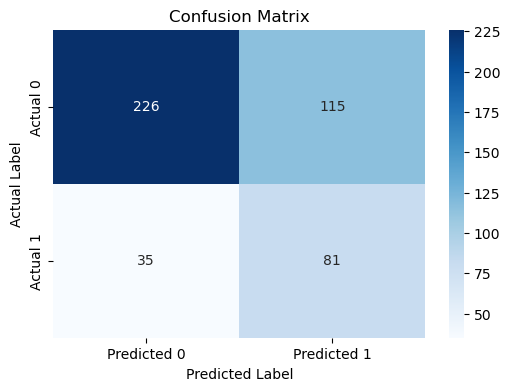

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.67      0.76       341
           1       0.42      0.71      0.53       116

    accuracy                           0.68       457
   macro avg       0.65      0.69      0.65       457
weighted avg       0.76      0.68      0.70       457



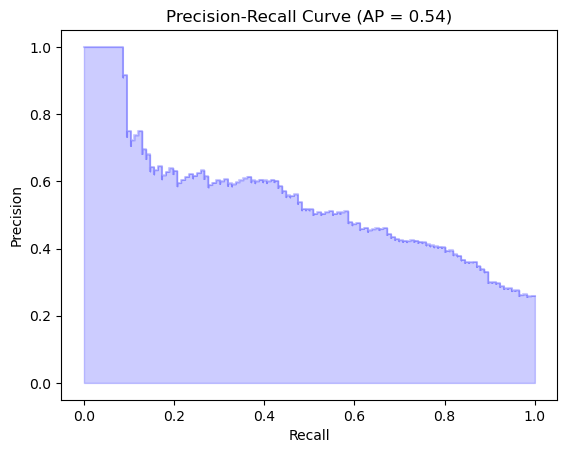

In [18]:
# 그리고 싶은 confusion matrix index
idx = 1 

cm = confusion_matrix(test_data['y'], y_pred_list[idx])

# Confusion Matrix 시각화
cm_df = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

# Classification Report 출력
print("Classification Report:")
print(classification_report(test_data['y'], y_pred))

# Precision-Recall Curve 계산 및 시각화
precision, recall, _ = precision_recall_curve(test_data['y'], best_model.predict_proba(X_test)[:, 1])
average_precision = auc(recall, precision)
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AP = {average_precision:.2f})')
plt.show()
